In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime, sys, datetime, warnings
sys.path.append('../chargecurve/')
warnings.filterwarnings('ignore')

from scipy.optimize import curve_fit
from databases import load_base2_ftp, query_station
from functions import get_peaks, collect_charges
from chargecurve import AutoCharge, ChargingCurve
from plot import charges, chargecurvestation, fullchargecurve


hyundai = load_base2_ftp('ecu_bcddc2d07024')
hyundai = hyundai[hyundai.model == 'HYUNDAIIONIQ']

#select while charging data, for Hyundai the conditions are as below
mask = (hyundai.hvBatteryCurrent < 0) & (hyundai.rpmEmotor <=0) \
& (hyundai.timestamp > datetime.datetime(2019,12,1))

#find peaks to extract charging curves
peaks_id = get_peaks(hyundai[mask], 'hvSocActualDisplay')

# collect charging data as AutoCharge objects
hyundai_charges = collect_charges(hyundai[mask], peaks_id)

In [2]:
HyundaiCharges = ChargingCurve(hyundai_charges)

In [3]:
HyundaiCharges.data.chargepoint_id.unique()

array([106334., 128014., 126439., 126434.,  28547.,     nan,  95195.,
       101149., 126645., 103860., 104202.,  18324., 124679.,  83102.,
       128039., 130870., 130341., 126725., 130946., 128035., 126711.,
       126765.,  96482., 129866., 130867.,  91058.])

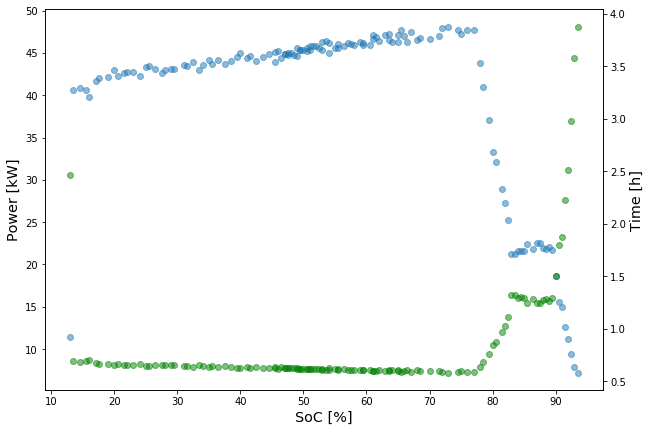

In [4]:
data = HyundaiCharges.ChargePointCurve(95195)
x = data.soc_display
y = data.power

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(x, y, 'o', alpha = 0.5)
ax1.set_ylabel('Power [kW]', fontsize='x-large')
ax1.set_xlabel('SoC [%]', fontsize='x-large')
ax2 = ax1.twinx()
ax2.set_ylabel('Time [h]', fontsize='x-large')
ax2.plot(x, 28/y, 'o', c='green', alpha = 0.5)


In [5]:
(28/y *60).describe()


count    129.000000
mean      50.285258
std       32.933534
min       34.914228
25%       36.549866
50%       37.769648
75%       41.001669
max      232.747569
Name: power, dtype: float64

Text(0, 0.5, 'SoC [%]')

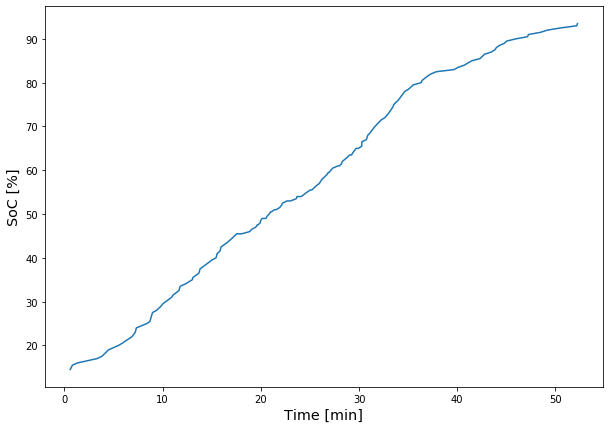

In [6]:
data['time'] = 28/data['power']
data['remainingTime'] = 28*(1-data['soc_display'][1:]/100)/data['power'][1:]
data['elapsedTime'] = abs((data['remainingTime']*60).diff(1)).cumsum()

plt.figure(figsize=(10,7))
plt.plot(data.elapsedTime, data.soc_display)
plt.xlabel('Time [min]', fontsize='x-large')
plt.ylabel('SoC [%]', fontsize='x-large')


In [7]:
#durantion charge between 10 and 80 %

_=data[(data['soc_display'] < 90) & (data['soc_display'] > 80)]['elapsedTime']

_.max()-_.min()


8.62037290711573

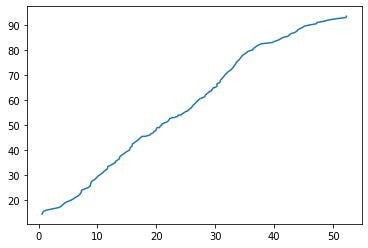

In [26]:
%matplotlib inline
plt.plot(abs((data.remainingTime*60).diff(1)).cumsum(), data.soc_display)

<IPython.core.display.Javascript object>


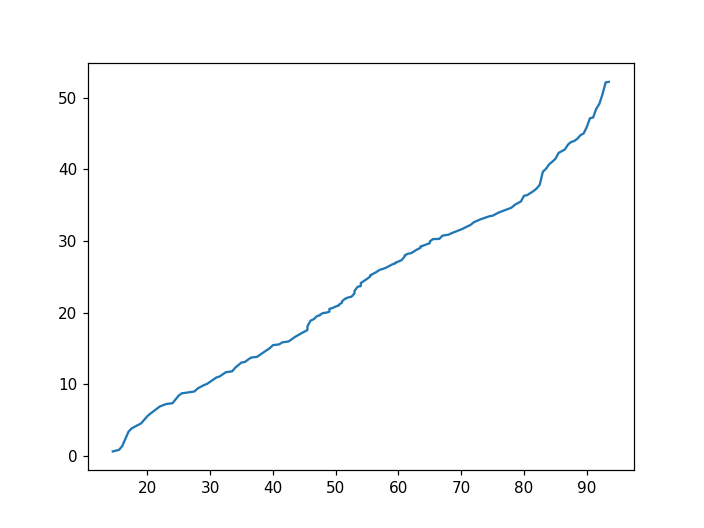

In [34]:
%matplotlib nbagg
plt.plot(data.soc_display, data.elapsedTime)

In [9]:
abs((data.remainingTime*60).diff(1)).sum()

52.23782106559799

In [12]:
data

soc_display      power  battery_temp  chargepoint_id  chargepoint_kw  \
16           13.0  11.375760          10.0         95195.0            50.0   
19           13.5  40.671540          10.0         95195.0            50.0   
29           14.5  40.880278          10.0         95195.0            50.0   
47           15.5  40.666751          10.0         95195.0            50.0   
49           16.0  39.835999          10.0         95195.0            50.0   
...           ...        ...           ...             ...             ...   
1518         91.5  12.572221          19.0         95195.0            50.0   
1521         92.0  11.144460          19.0         95195.0            50.0   
1525         92.5   9.397050          19.0         95195.0            50.0   
1528         93.0   7.813021          19.0         95195.0            50.0   
1530         93.5   7.218121          19.0         95195.0            50.0   

          time  remainingTime  elapsedTime  
16    2.461374            NaN          NaN  
19    0.688442       0.595502          NaN  
29    0.684927       0.585612     0.593398  
47    0.688523       0.581802     0.822020  
49    0.702882       0.590421     1.339140  
...        ...            ...          ...  
1518  2.227132       0.189306    48.467604  
1521  2.512459       0.200997    49.169033  
1525  2.979658       0.223474    50.517692  
1528  3.583761       0.250863    52.161026  
1530  3.879126       0.252143    52.237821  

[129 rows x 8 columns]

In [35]:
from scipy.interpolate import interp1d 

ccurve = interp1d(data.soc_display,data.elapsedTime)
round(ccurve(90)-ccurve(80))

10.0

In [30]:
data[(data.soc_display >= 29) & (data.soc_display <= 31 )][['elapsedTime','soc_display']]

elapsedTime  soc_display
350     9.859351         29.0
374    10.023627         29.5
412    10.926333         31.0